# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

---
We begin by looking at the architecture:
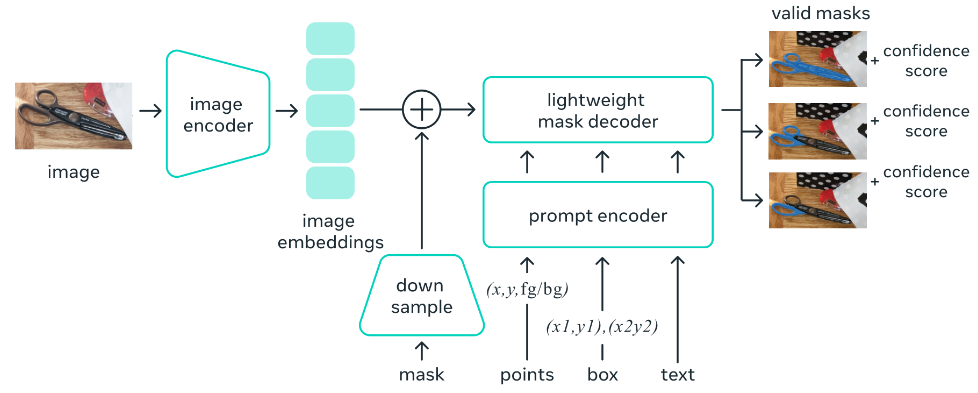

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box

## Let's begin!

## Install Segment Anything Model (SAM) and other dependencies

In [1]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

  Preparing metadata (setup.py) ... done


In [2]:
!pip install -q jupyter_bbox_widget dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.3 MB/s eta 0:00:00


### Download SAM weights

In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-07-12 11:56:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   254MB/s    in 14s     

2023-07-12 11:56:21 (181 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## Download Example Data

Let's download an example image. Feel free to use your images or videos.

In [4]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=18ZzNWMv3-8bFausBqTLuJv6BOiwl-77k

Downloading...
From: https://drive.google.com/uc?id=18ZzNWMv3-8bFausBqTLuJv6BOiwl-77k
To: /content/dog.jpeg
100% 227k/227k [00:00<00:00, 160MB/s]


## Load Model

In [5]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [6]:
print(DEVICE)

cuda


In [7]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint="sam_vit_h_4b8939.pth").to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)

### Generate masks with SAM

In [9]:
import cv2
import supervision as sv

image_bgr = cv2.imread("dog.jpeg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [11]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation

In [12]:
# utility code to plot image grid
import cv2
import matplotlib.pyplot as plt
import numpy as np

def plot_images_grid(
    images, grid_size, titles = None, size = (12, 12), cmap = "gray"
):

    nrows, ncols = grid_size

    if len(images) > nrows * ncols:
        raise ValueError(
            "The number of images exceeds the grid size. Please increase the grid size or reduce the number of images."
        )

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            if images[idx].ndim == 2:
                ax.imshow(images[idx], cmap=cmap)
            else:
                ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))

            if titles is not None and idx < len(titles):
                ax.set_title(titles[idx])

        ax.axis("off")
    plt.show()

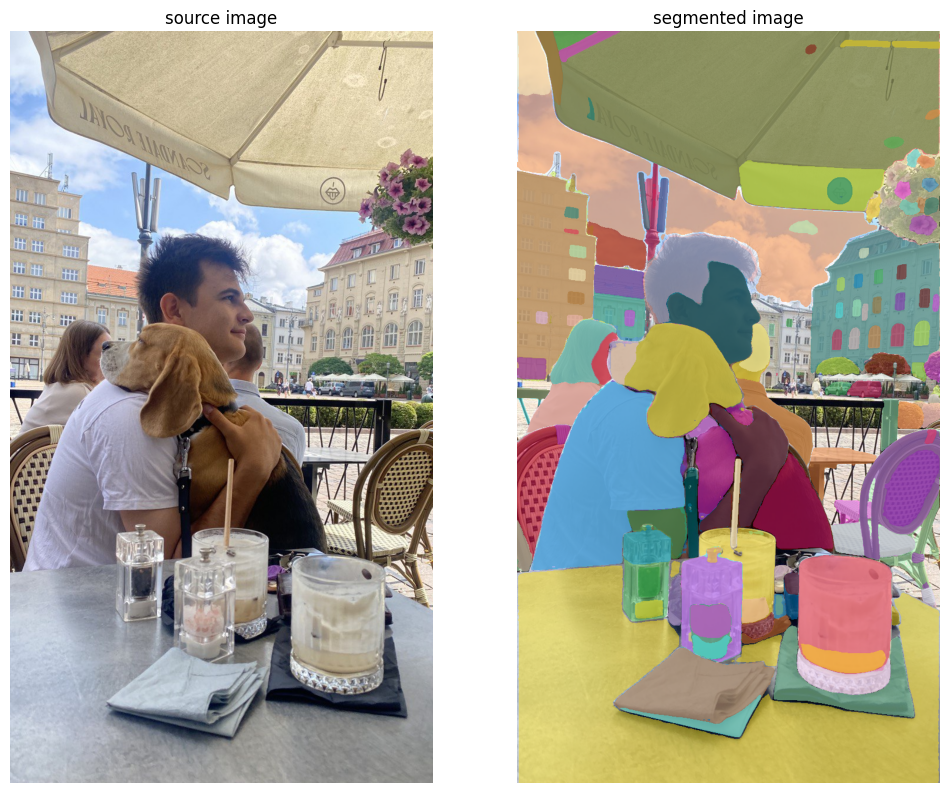

In [13]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

import cv2
import matplotlib.pyplot as plt
import numpy as np### Interaction with segmentation results

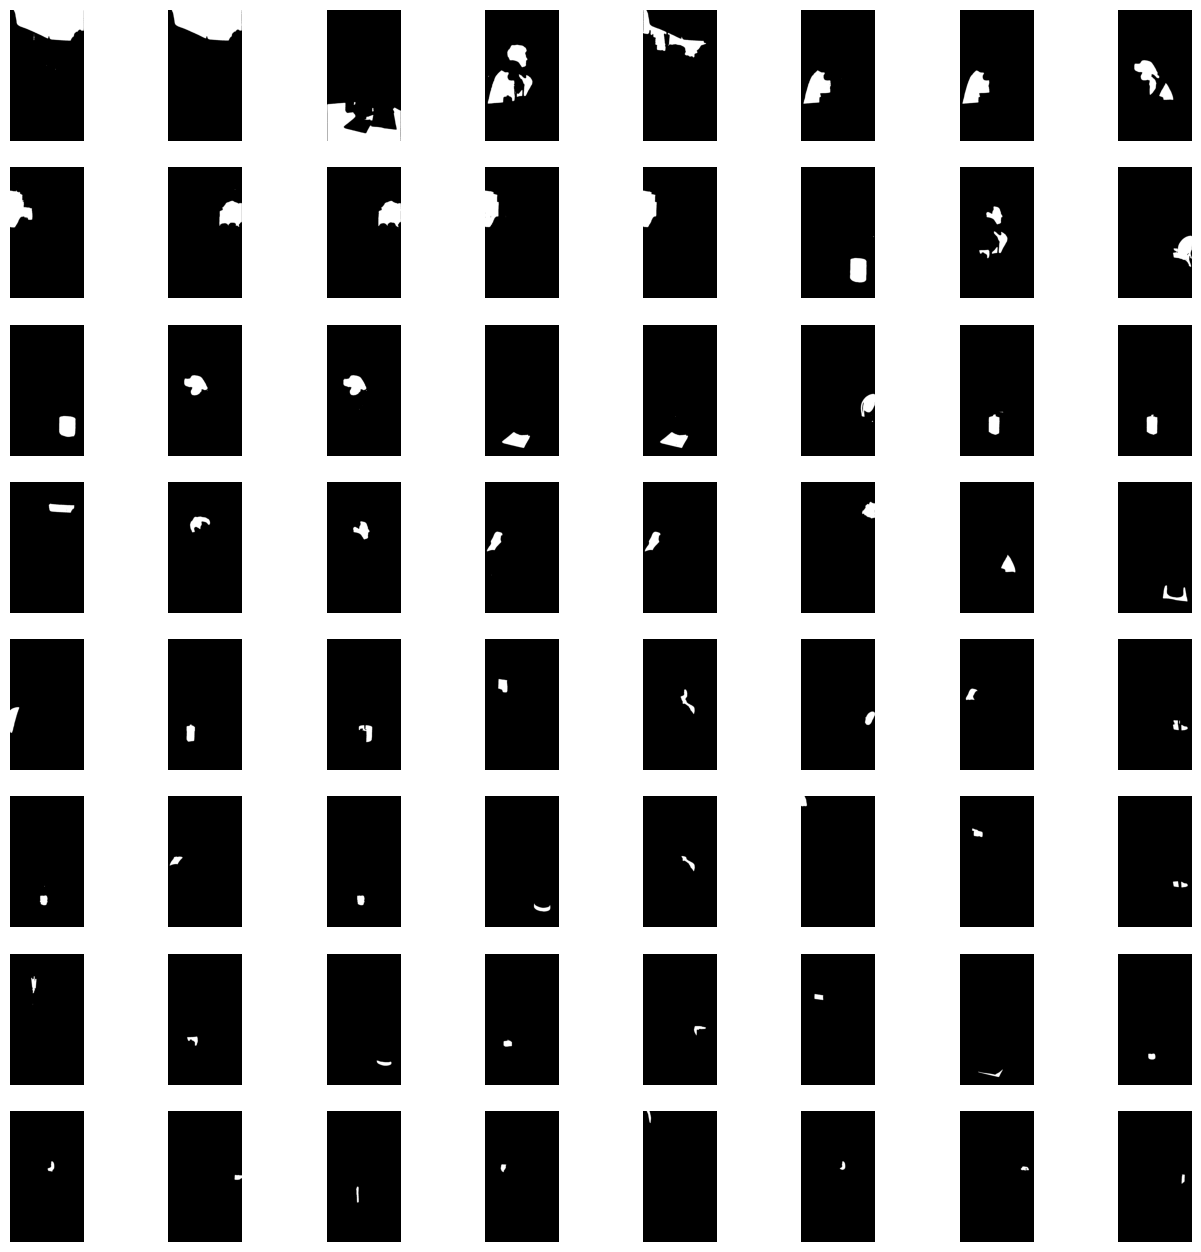

In [14]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:64],
    grid_size=(8, int(len(masks[:64]) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [15]:
mask_predictor = SamPredictor(sam)

### Draw Box



In [16]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [30]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image("dog.jpeg")
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [31]:
widget.bboxes

[{'x': 157, 'y': 472, 'width': 259, 'height': 262, 'label': ''},
 {'x': 210, 'y': 337, 'width': 220, 'height': 236, 'label': ''},
 {'x': 297, 'y': 812, 'width': 157, 'height': 234, 'label': ''},
 {'x': 470, 'y': 870, 'width': 178, 'height': 266, 'label': ''},
 {'x': 177, 'y': 833, 'width': 89, 'height': 180, 'label': ''},
 {'x': 152, 'y': 1050, 'width': 302, 'height': 158, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [32]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [33]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread("dog.jpeg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

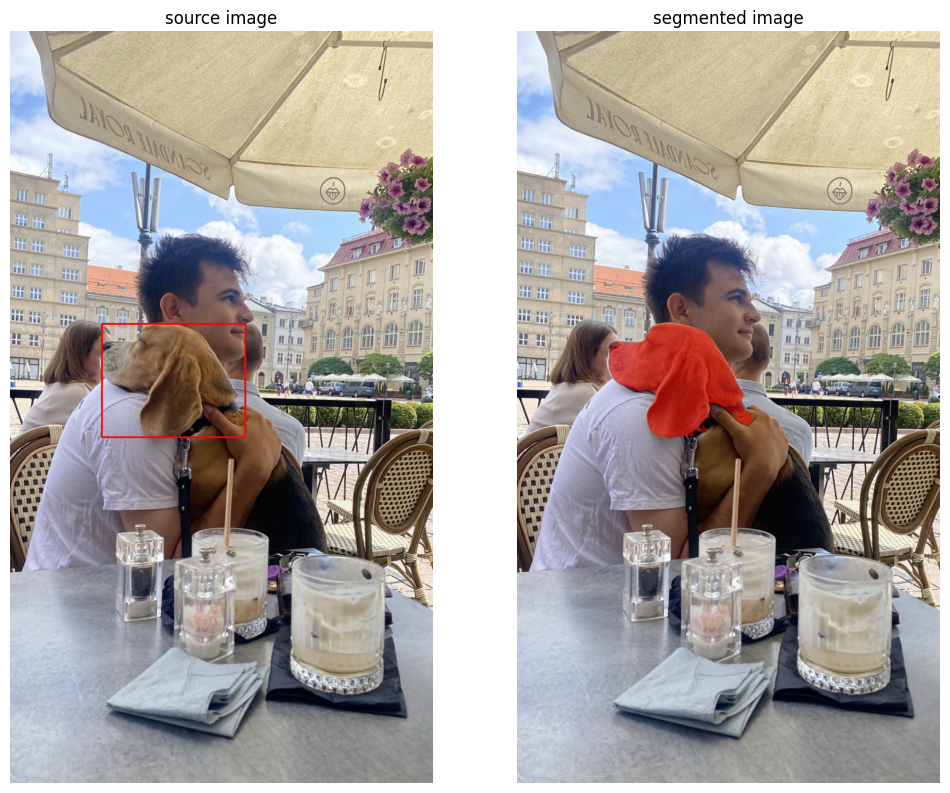

In [34]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

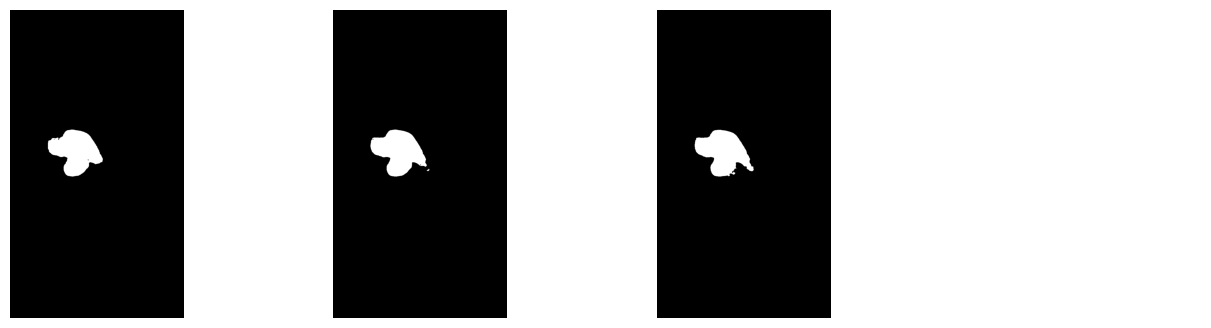

In [35]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)